# Data Exploration & Image Pre-Processing

In the first assignment of this course, you will work with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). In this notebook, you'll get a chance to explore this dataset and familiarize yourself with some of the techniques you'll use in the first graded assignment.

<img src="images/xray-image.png" alt="U-net Image" width="300" align="middle"/>

The first step before jumping into writing code for any machine learning project is to explore your data. A standard Python package for analyzing and manipulating data is [pandas](https://pandas.pydata.org/docs/#). 

With the next two code cells, you'll import `pandas` and a package called `numpy` for numerical manipulation, then use `pandas` to read a csv file into a dataframe and print out the first few rows of data.

In [21]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set()

List the directory structure

In [22]:
!ls -a

.
..
C1_W1_Lab_1_data_exploration_and_image_preprocessing.ipynb
C1_W1_Lab_2_counting_labels_and_weighted_loss_function.ipynb
C1_W1_Lab_3_densenet.ipynb
C1_W1_Lab_4_patient_overlap_and_data_leakage.ipynb
data
._data
images
.ipynb_checkpoints
models


## 1. Exploration

Read the data from `csv` files.

In [23]:
# Read csv file containing training datadata
train_df = pd.read_csv("data/nih/train-small.csv")
# Print first 5 rows
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame')
train_df.head()

There are 1000 rows and 16 columns in this data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


Have a look at the various columns in this csv file. The file contains the names of chest x-ray images ("Image" column) and the columns filled with ones and zeros identify which diagnoses were given based on each x-ray image. 

### 1.1 Data Types and Null Values Check

Run the next cell to explore the data types present in each column and whether any null values exist in the data.

In [24]:
# Look at the data type of each column and whether null values are present
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
Image                 1000 non-null object
Atelectasis           1000 non-null int64
Cardiomegaly          1000 non-null int64
Consolidation         1000 non-null int64
Edema                 1000 non-null int64
Effusion              1000 non-null int64
Emphysema             1000 non-null int64
Fibrosis              1000 non-null int64
Hernia                1000 non-null int64
Infiltration          1000 non-null int64
Mass                  1000 non-null int64
Nodule                1000 non-null int64
PatientId             1000 non-null int64
Pleural_Thickening    1000 non-null int64
Pneumonia             1000 non-null int64
Pneumothorax          1000 non-null int64
dtypes: int64(15), object(1)
memory usage: 125.1+ KB


### 1.2 Unique IDs Check

"PatientId" has an identification number for each patient. One thing you'd like to know about a medical dataset like this is if you're looking at repeated data for certain patients or whether each image represents a different person.

In [25]:
print(f"The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")

The total patient ids are 1000, from those the unique ids are 928 


As you can see, the number of unique patients in the dataset is less than the total number so there must be some overlap. For patients with multiple records, you'll want to make sure they do not show up in both training and test sets in order to avoid data leakage (covered later in this week's lectures).

### 1.3 Data Labels

Run the next two code cells to create a list of the names of each patient condition or disease. 

In [26]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [27]:
# Remove unnecesary elements
columns.remove('Image')
columns.remove('PatientId')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Run the next cell to print out the number of positive labels (1's) for each condition

In [28]:
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


Have a look at the counts for the labels in each class above. Does this look like a balanced dataset?

### 1.4 Data Visualization

Using the image names listed in the csv file, you can retrieve the image associated with each row of data in your dataframe. 

Run the cell below to visualize a random selection of images from the dataset.

Display Random Images


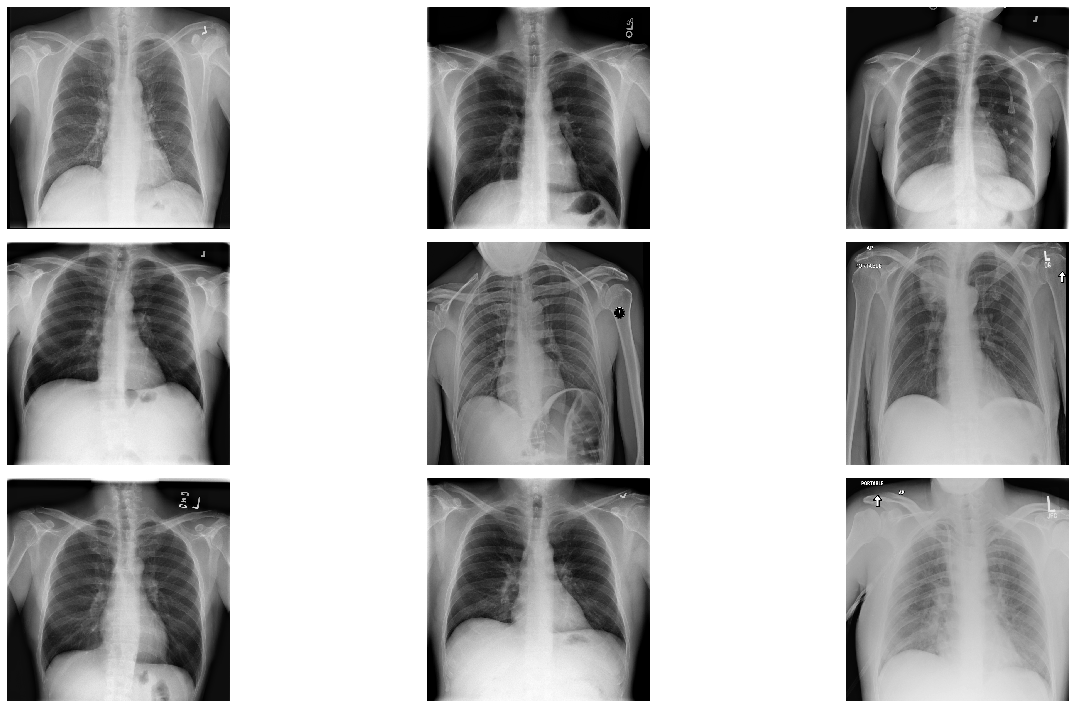

In [29]:
# Extract numpy values from Image column in data frame
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'data/nih/images-small/'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

### 1.5 Investigating a Single Image

Run the cell below to look at the first image in the dataset and print out some details of the image contents.

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


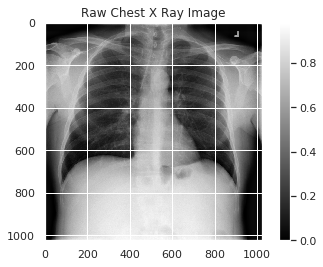

In [30]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### 1.6 Investigating Pixel Value Distribution

Run the cell below to plot up the distribution of pixel values in the image shown above. 

Text(0, 0.5, '# Pixels in Image')

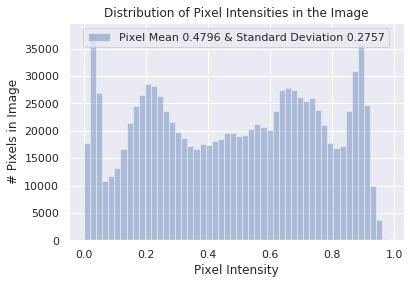

In [31]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

## 2. Image Preprocessing in Keras

Before training, you'll first modify your images to be better suited for training a convolutional neural network. For this task you'll use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.

Run the next two cells to import this function and create an image generator for preprocessing.

In [32]:
# Import data generator from keras
from keras.preprocessing.image import ImageDataGenerator

In [33]:
# Normalize images
image_generator = ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True # Divide each input by its standard deviation
)

### 2.1 Standardization

The `image_generator` you created above will act to adjust your image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.  

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

Run the next cell to pre-process your data using the `image_generator`. In this step you will also be reducing the image size down to 320x320 pixels.

In [34]:
# Flow from directory with specified batch size and target image size
generator = image_generator.flow_from_dataframe(
        dataframe=train_df,
        directory="data/nih/images-small/",
        x_col="Image", # features
        # Let's say we build a model for mass detection
        y_col= ['Mass'], # labels
        class_mode="raw", # 'Mass' column should be in train_df
        batch_size= 1, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(320,320) # width and height of output image
)

Found 1000 validated image filenames.


Run the next cell to plot up an example of a pre-processed image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 1.7999 and the minimum is -1.7404
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


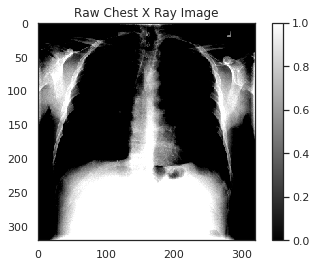

In [35]:
# Plot a processed image
sns.set_style("white")
generated_image, label = generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Run the cell below to see a comparison of the distribution of pixel values in the new pre-processed image versus the raw image. 

Text(0, 0.5, '# Pixel')

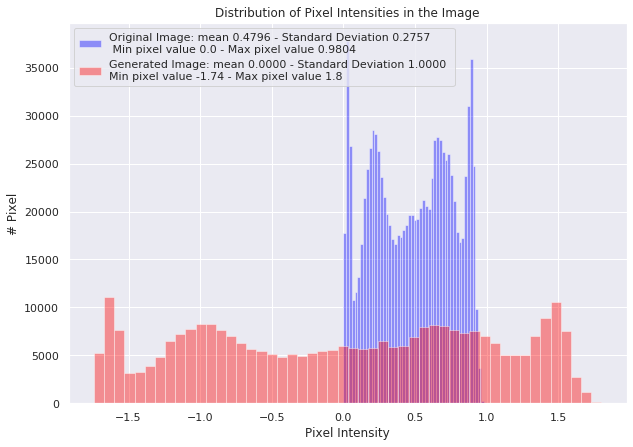

In [36]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

That's it for this exercise, you should now be a bit more familiar with the dataset you'll be using in this week's assignment!